# Goal
The goal of this quick starter guide is to very quickly go through time-series modeling pipeline. This tutorial does not intend to get deep into concepts of time-series modeling and only uses a very clean dataset. To use an analogy from learning music, the intention is to help the reader to play a few basic songs on the instrument before being disheartened by musical theory.

By the end of this tutorial you should be able to:

1. Preprocess your data.
2. Develop a baseline model.
3. Improve your baseline model.


In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# The Strategy
The dataset that is used in this tutorials includes tweet volume for the hashtag **#AMZN**. We load the csv file directly into a `pandas` dataframe, run a few quick checks and descriptive statistics to have an idea of what the dataset is all about and we build a baseline neural model using MLP. 

# The Dataset
The dataset is located in [Numenta Anomaly Detection Benchmark](https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv). The dataset is based on real-time streaming data from Twitter with **#AMZN** hashtag.

In [117]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"

## Loading the data
The dataset includes only two columns, *timestamp* and *value*. Each line represents a five-minute aggregate of AMZN tweet volume.

In [127]:
df = pd.read_csv(url)
df.head()

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43
2,2015-02-26 21:52:53,55
3,2015-02-26 21:57:53,64
4,2015-02-26 22:02:53,93


## Checking for missing data
`pandas.isna()` returns `True` or `False` for every record in the dataframe. True indicates that at a certain position in the dataset, a value is missing. The output of `isna()` is a DataFrame, so we can aggregate the values using `sum` to retrieve the total number of missing values per column.

In [128]:
df.isna().sum()

timestamp    0
value        0
dtype: int64

There are no missing values in the dataset

### Which year/month do we have data from?
First we check what years we have data for. As you can see data is only from 2015.
We also have data only for February till April. February data seems to be incomplete as well

In [129]:
dt = pd.to_datetime(df.timestamp)
dt.groupby([dt.dt.year, dt.dt.month]).count()

timestamp  timestamp
2015       2             604
           3            8928
           4            6299
Name: timestamp, dtype: int64

## Converting Timestamp to Readable Dates

In [130]:
df['timestamp_readable'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').ctime()[:-4]).astype('str')
df.head()


,timestamp,value,timestamp_readable
0,2015-02-26 21:42:53,57,Thu Feb 26 21:42:53
1,2015-02-26 21:47:53,43,Thu Feb 26 21:47:53
2,2015-02-26 21:52:53,55,Thu Feb 26 21:52:53
3,2015-02-26 21:57:53,64,Thu Feb 26 21:57:53
4,2015-02-26 22:02:53,93,Thu Feb 26 22:02:53


This will help us uncover seasonnality events

## Basic Descriptive Statistics
Using `describe` we can get a quick descriptive report on the dataset. Since the data includes only one numerical column, value, we can improve the readability, using `no.transpose()` or `np.T`.

`df.describe` by default only includes numerical values, but we could pass `include='all'` to the function to include all field. In the case of timestamp, the output would be of no interest to us, so we do not change default values.

In [131]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
value,15831.0,53.298465,30.553147,0.0,36.0,50.0,65.0,1673.0


**Notable Observations**
- There are 15831 rows of data
- min==0.0, therefore there exists at least one row with `value==0`. It could be possible that missing values are replaced with zeros, so we would like to check that the total number of zeros are not significant. We run a count on `df.value==0`, and if the output shows only a small number of rows are zero, then we accept those zeros and  acceptable, accurate, or ignorable.
- In this case, only 28 rows have value of zero, so we keep them as they are.

In [132]:
df[df.value==0].count()

timestamp             28
value                 28
timestamp_readable    28
dtype: int64

## Plotting the Data
The data is showing signs of seasonality, indeed we notice that we have a peak for each day, most likely corresponding to day time / night time.
We can also see that the activity seems more limited on the Saturday and Sunday

In [133]:
fourteen_days = 24*60*14//5  # Seven days of the data that is sampled every 5 minutes

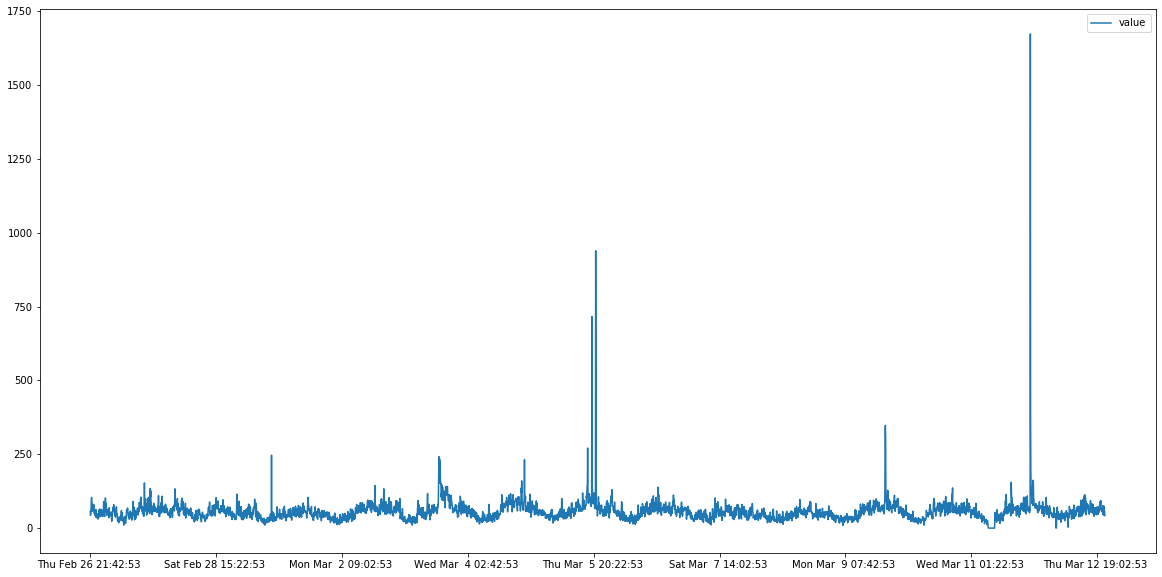

In [134]:
ax = df[:seven_days].plot(y='value', figsize=(20,10), sharex=False)
o = ax.set_xticklabels([df.timestamp_readable[int(x)] if x >= 0 else '' for x in ax.get_xticks()])

## Are there any patterns in the data if we reduce granularity? 
Very often short term data is far too jittery and all that can be observed is white noise. There are several techniques to address the issue and try to understand whether there are underlying patterns in the data.
Aggregation and smoothing are amongst those techniques.

In the next few cells, the data has been aggregated to hourly average per month in order to investigate if there are patterns hidden in the data.

The data in the dataset sums the number of twits every five minutes. It is useful for short term prediction of immediate actions. Such data is similar to that of financial data such as stock prices for short term trade.

Aggregated data will reduce granularity and helps us predict seasonal and long term non-stationary time series. This is more similar to use cases such as forecasting weather patterns.

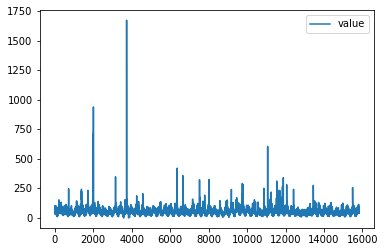

In [135]:
df.plot()

Plotting several hours, hour by hour to understand if they are any internal patterns. As the data has a 5 minute frequency, 12 * 5 minutes represents 1 hour.

We then plot a histogram of data to understand how the data is distributed. It could be observed from the previous plot that most data were around 0-100. From the histogram we can see the point more clearly.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c06ff4f98>]],
      dtype=object)

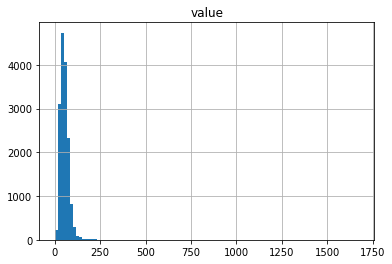

In [136]:
df.hist(column=['value'], bins=100)

### Daily Patterns

In [138]:
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [164]:
df.iloc[28]

value                                   39
timestamp_readable    Fri Feb 27 00:02:53 
Name: 2015-02-27 00:02:53, dtype: object

In [166]:
offset = 28 # We offset to 28 to start the day closest to 12am

Plotting separate days, day by day, to understand daily patterns. 288/12=24 hour.

In [167]:
number_of_timestamps_per_day = 24*60//5

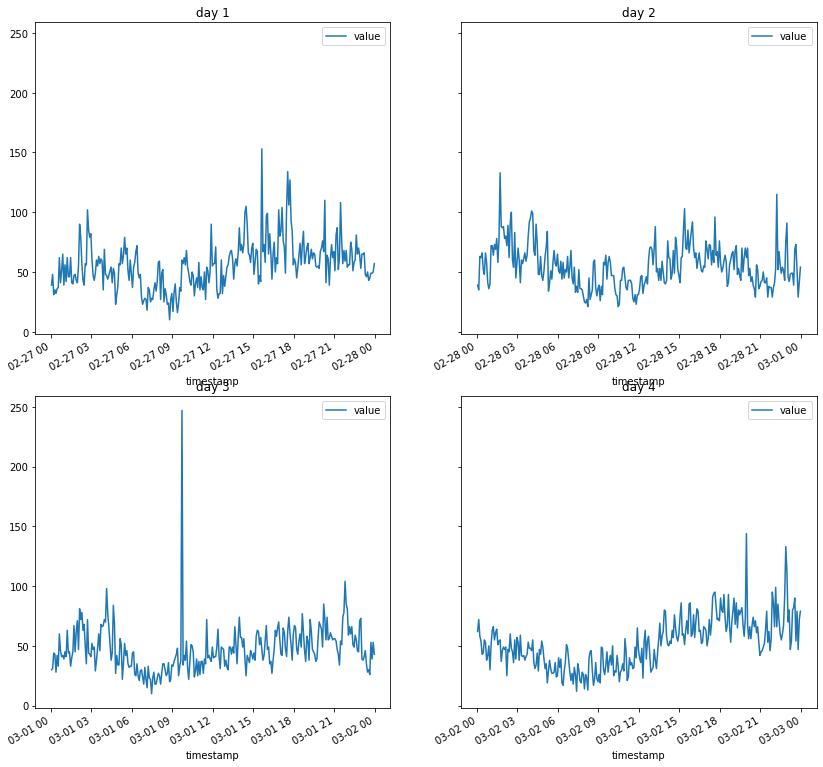

In [168]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14), sharey=True)

df[offset:number_of_timestamps_per_day+offset].plot(ax=axes[0,0], title='day 1')
df[1*number_of_timestamps_per_day+offset:2*number_of_timestamps_per_day+offset].plot(ax=axes[0,1], title='day 2')
df[2*number_of_timestamps_per_day+offset:3*number_of_timestamps_per_day+offset].plot(ax=axes[1,0], title='day 3')
df[3*number_of_timestamps_per_day+offset:4*number_of_timestamps_per_day+offset].plot(ax=axes[1,1], title='day 4')

We can try to compute the moving average to remove the noise

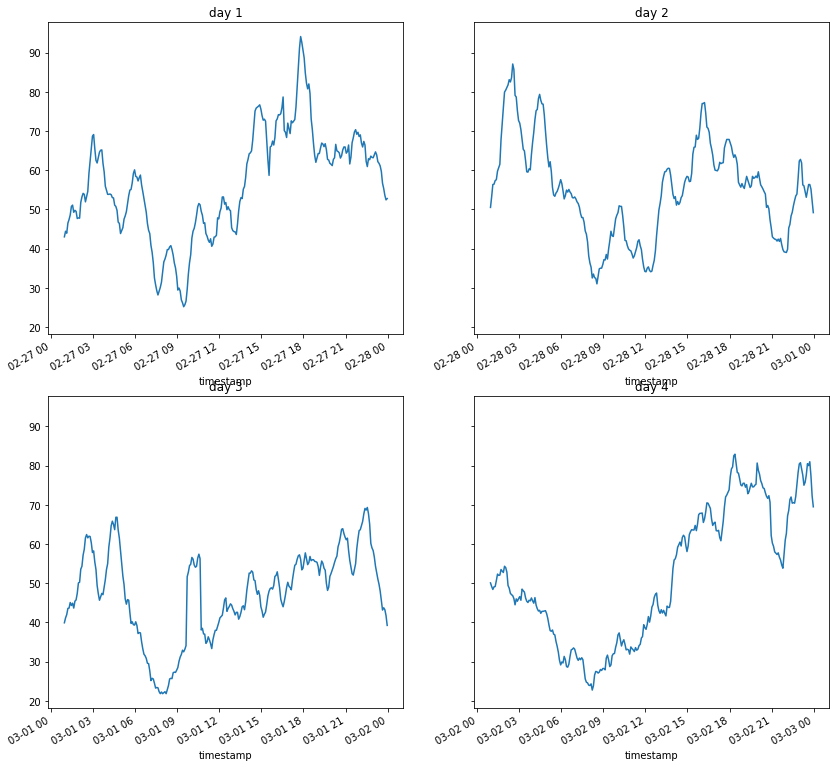

In [197]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14), sharey=True)

df[offset:number_of_timestamps_per_day+offset].value.rolling(window=12).mean().plot(ax=axes[0,0], title='day 1')
df[1*number_of_timestamps_per_day+offset:2*number_of_timestamps_per_day+offset].value.rolling(window=12).mean().plot(ax=axes[0,1], title='day 2')
df[2*number_of_timestamps_per_day+offset:3*number_of_timestamps_per_day+offset].value.rolling(window=12).mean().plot(ax=axes[1,0], title='day 3')
df[3*number_of_timestamps_per_day+offset:4*number_of_timestamps_per_day+offset].value.rolling(window=12).mean().plot(ax=axes[1,1], title='day 4')

Now if we average this across all days we can see the daily pattern even more clearer

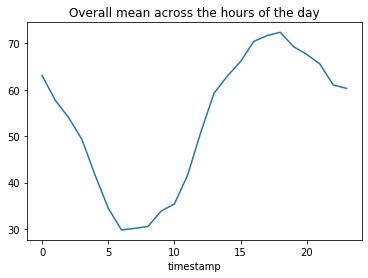

In [176]:
o = df.value.groupby(df.index.hour).mean().plot(title="Overall mean across the hours of the day")

### Standardizing the Data
- In order to experiment as whether we can reduce jitters in the data we can try to standardize the data.
- Standardization is calculating the standard score of the data using $\Large {z = \frac {(X-\mu)}{\sigma}}$, in which $\mu$ is the mean and $\sigma$ is the standard deviation.
- This results the transforming the data for standard deviation to be 1.

In [188]:
from sklearn.preprocessing import StandardScaler
def standardize(data):
    scaler = StandardScaler() 
    print("BEFORE STANDARDIZING:\nMEAN: {}; STD: {}".format(data.mean(axis=0), 
                                                            data.std(axis=0)))
    data_scaled = scaler.fit_transform(data.reshape((-1,1)))
    print("AFTER STANDARDIZING:\nMEAN: {}; STD: {}".format(data_scaled.mean(axis=0), 
                                                           data_scaled.std(axis=0)))
    return data_scaled


In [193]:
df['value_normalized']=standardize(df.value)

BEFORE STANDARDIZING:
MEAN: 53.29846503695281; STD: 30.55314720842815
AFTER STANDARDIZING:
MEAN: [4.30876777e-17]; STD: [1.]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
